# Assess thresholds to use for similarity decision

We want to choose a threshold for Tanimoto similarity that compounds need to have to be considered similar to training data. We use 10000 random products from the VL to assess the typical distribution of Tanimoto coefficients.


In [1]:
import pathlib
import statistics
import sys
sys.path.append(str(pathlib.Path("__file__").absolute().parents[1]))
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader

from src.model.classifier import load_trained_model
from inference import import_valid_smiles_from_vl
from src.data.dataloader import SLAPProductDataset, collate_fn
from src.data.util import SLAPReactionSimilarityCalculator, SLAPReactionGenerator
from src.util.rdkit_util import canonicalize_smiles

In [2]:
# Import product SMILES and generate reactionSMILES. This will take some time.
# This will throw warnings if any reactions cannot be generated, 
# e.g. if there are two morpholines in the same product.
raw_dir = pathlib.Path("../data/")  # <-- change me
filename_base = "tsne_plot_2023-02-03_smiles_only_random"  # <-- change me
valid_idx_file = None  # <-- change me or set me to None
df = import_valid_smiles_from_vl(raw_dir, filename_base, valid_idx_file=valid_idx_file)
data = SLAPProductDataset(smiles=df["smiles"].values.tolist())

Error leading to this warning: More than two possible reactions found.
Error leading to this warning: Encountered RuntimeError while generating reaction for product 'CC1OCC(c2cccc3cc[nH]c23)NC1C1CC[Si](C)(C)C1'.
Original error message: More than one reaction found for SLAP reagent 'CC(OC[Si](C)(C)C)C(N)C1CC[Si](C)(C)C1' and aldehyde 'O=Cc1cccc2cc[nH]c12'.
Reactions:
C[Si]1(C)[CH2:8][CH2:7][CH:6]([CH:4]([CH:3]([CH3:17])[O:18][CH2:19][Si:20]([CH3:21])([CH3:22])[CH3:23])[NH2:5])[CH2:24]1.O=[CH:2][c:1]1[cH:9][cH:11][cH:14][c:13]2[c:10]1[nH:12][cH:15][cH:16]2>>[c:1]1([CH:2]2[NH:5][CH:4]([CH:3]([CH3:17])[O:18][CH2:19][Si:20]([CH3:21])([CH3:22])[CH3:23])[CH:6]([CH3:24])[CH2:7][CH2:8]2)[cH:9][cH:11][cH:14][c:13]2[c:10]1[nH:12][cH:15][cH:16]2
C[Si](C)(C)[CH2:8][O:7][CH:6]([CH:4]([CH:3]1[CH2:17][CH2:19][Si:20]([CH3:21])([CH3:22])[CH2:18]1)[NH2:5])[CH3:23].O=[CH:2][c:1]1[cH:9][cH:11][cH:14][c:13]2[c:10]1[nH:12][cH:15][cH:16]2>>[c:1]1([CH:2]2[NH:5][CH:4]([CH:3]3[CH2:17][CH2:19][Si:20]([CH3:21])([C

In [3]:
reac_gen = SLAPReactionGenerator()

In [4]:
reac_gen.initialize_dataset("../data/reactionSMILESunbalanced_LCMS_2022-08-25_without_validation.csv")

In [5]:
similarity_calculator = SLAPReactionSimilarityCalculator(*reac_gen.get_reactants_in_dataset())

In [6]:
len(reac_gen.get_reactants_in_dataset())

2

In [7]:
similarities_slap = np.zeros((len(data.reactants), len(reac_gen.get_reactants_in_dataset()[0])))
similarities_aldehyde = np.zeros((len(data.reactants), len(reac_gen.get_reactants_in_dataset()[1])))

In [8]:
similarities_aldehyde.shape

(15559, 48)

In [9]:
for i, (slap, ald) in enumerate(data.reactants):
    sim_s, sim_a = similarity_calculator.calculate_similarity(reactants=(slap, ald))
    similarities_slap[i] = sim_s
    similarities_aldehyde[i] = sim_a

In [10]:
similarities_slap

array([[0.47887324, 0.52631579, 0.48214286, ..., 0.64814815, 0.47368421,
        0.59259259],
       [0.53125   , 0.53846154, 0.58333333, ..., 0.64      , 0.57142857,
        0.7173913 ],
       [0.52857143, 0.48333333, 0.51785714, ..., 0.46774194, 0.50877193,
        0.51724138],
       ...,
       [0.50724638, 0.50877193, 0.54716981, ..., 0.57142857, 0.56603774,
        0.63461538],
       [0.62962963, 0.55555556, 0.6097561 , ..., 0.6744186 , 0.5952381 ,
        0.725     ],
       [0.53731343, 0.60377358, 0.55769231, ..., 0.64150943, 0.57692308,
        0.61538462]])

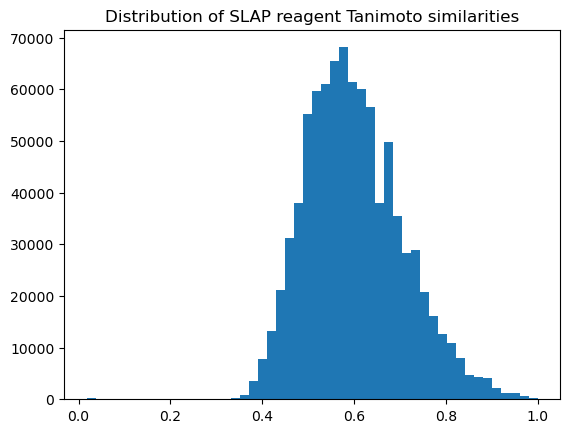

In [11]:
plt.figure()
plt.hist(similarities_slap.flatten(), bins=50)
plt.title("Distribution of SLAP reagent Tanimoto similarities")
plt.show()

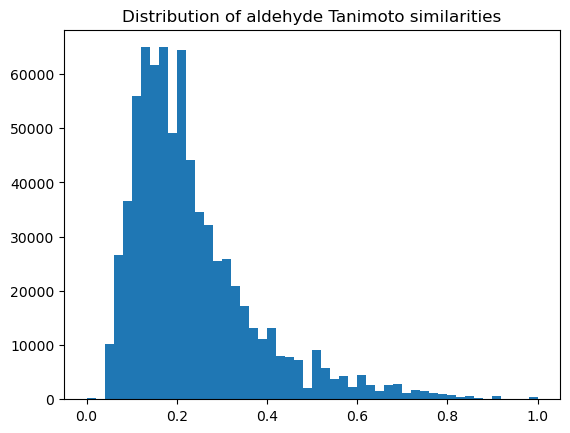

In [12]:
plt.hist(similarities_aldehyde.flatten(), bins=50)
plt.title("Distribution of aldehyde Tanimoto similarities")
plt.show()

In [13]:
np.quantile(similarities_slap.flatten(), 0.90)

0.7441860465116279

In [14]:
np.quantile(similarities_aldehyde.flatten(), 0.90)

0.4186046511627907

### Conclusion
From the distributions, it is obvious that we cannot use the same threshold for SLAP reagent and aldehyde similarity.
We use the 90th percentile as the threshold, so ca. 0.74 for SLAP reagents and 0.42 for aldehydes.

In [15]:
similarity = []
for i, (slap, ald) in enumerate(data.reactants):
    sim = similarity_calculator.is_similar(reactants=(slap, ald),
                                                    slap_similarity_threshold=0.74, 
                                                    aldehyde_similarity_threshold=0.42
                                                   )
    similarity.append(sim)

In [16]:
similarity.count(False)

9190

In [17]:
similarity.count(True)

6369